<a href="https://colab.research.google.com/github/CallMeL/Medical-Image-Segmentation/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 数据集准备
在def __init__(self,path)中的seglist、imglist根据自己目录文件来确定。


In [35]:
import os
from torch.utils.data import Dataset
from torch.utils import *
from torchvision import transforms
from PIL import Image

In [36]:
def keep_image_size_open(path, size=(256, 256)):
    img = Image.open(path)
    temp = max(img.size)
    mask = Image.new('RGB', (temp, temp), (0, 0, 0))
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask

In [37]:
transform = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.ToTensor()])

## 眼球的数据集
path = /content/drive/MyDrive/CENet/CE-Net/dataset/DRIVE/training

In [38]:
class myDataset(Dataset):
  def __init__(self,path):
    self.path = path 
    self.seglist = os.listdir(os.path.join(path,'1st_manual'))
    self.imglist = os.listdir(os.path.join(path,'images'))


  def __len__(self):
    return len(self.seglist)
  
  def __getitem__(self,index):
    segment_name = self.seglist[index] #
    segment_path = os.path.join(self.path,'1st_manual',segment_name)
    image_name = self.imglist[index]
    image_path = os.path.join(self.path,'images',image_name)
    segment = keep_image_size_open(segment_path)
    image = keep_image_size_open(image_path)
    return transform(segment),transform(image)

In [39]:
data = myDataset('/content/drive/MyDrive/CENet/CE-Net/dataset/DRIVE/training')

In [40]:
print(data[0][0].shape) #已经分割的
print(data[0][1].shape) #原始图像

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


## 体细胞数据集
path = /content/drive/MyDrive/unet/data/train

In [ ]:
class myDataset(Dataset):
  def __init__(self,path):
    self.path = path 
    self.seglist = os.listdir(os.path.join(path,'1st_manual'))
    self.imglist = os.listdir(os.path.join(path,'images'))


  def __len__(self):
    return len(self.seglist)
  
  def __getitem__(self,index):
    segment_name = self.seglist[index] #
    segment_path = os.path.join(self.path,'1st_manual',segment_name)
    image_name = self.imglist[index]
    image_path = os.path.join(self.path,'images',image_name)
    segment = keep_image_size_open(segment_path)
    image = keep_image_size_open(image_path)
    return transform(segment),transform(image)

# network
这里是三个模块：卷积、上采样、下采样

左边是：【卷积、卷积】、下采样

右边是：【卷积、卷积】、上采样


## 卷积模块

In [41]:
import torch
from torch import nn
from torch.nn import functional as F

In [42]:
class Conv_Block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Conv_Block, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)

## 下采样模块
**原论文中用的是max pooling，但这样信息丢失过多，故改用为3*3conv，步长为2**

In [43]:
class DownSample(nn.Module):
    def __init__(self,channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)

## 上采样模块
使用插值法

要和对应的左边的图拼接之后再卷积

torch.cat((out,feature_map),dim=1)就是在做这样一件事

In [44]:
class UpSample(nn.Module):
    def __init__(self,channel):
        super(UpSample, self).__init__()
        self.layer=nn.Conv2d(channel,channel//2,1,1)
    def forward(self,x,feature_map):
        up=F.interpolate(x,scale_factor=2,mode='nearest')
        out=self.layer(up)
        return torch.cat((out,feature_map),dim=1)


## UNET

In [45]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.c1=Conv_Block(3,64)
        self.d1=DownSample(64)
        self.c2=Conv_Block(64,128)
        self.d2=DownSample(128)
        self.c3=Conv_Block(128,256)
        self.d3=DownSample(256)
        self.c4=Conv_Block(256,512)
        self.d4=DownSample(512)
        self.c5=Conv_Block(512,1024)
        self.u1=UpSample(1024)
        self.c6=Conv_Block(1024,512)
        self.u2 = UpSample(512)
        self.c7 = Conv_Block(512, 256)
        self.u3 = UpSample(256)
        self.c8 = Conv_Block(256, 128)
        self.u4 = UpSample(128)
        self.c9 = Conv_Block(128, 64)
        self.out=nn.Conv2d(64,3,3,1,1)
        self.Th=nn.Sigmoid()

    def forward(self,x):
        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        R3 = self.c3(self.d2(R2))
        R4 = self.c4(self.d3(R3))
        R5 = self.c5(self.d4(R4))
        O1=self.c6(self.u1(R5,R4))
        O2 = self.c7(self.u2(O1, R3))
        O3 = self.c8(self.u3(O2, R2))
        O4 = self.c9(self.u4(O3, R1))

        return self.Th(self.out(O4))

测试网络是否正确

In [46]:
if __name__ == '__main__':
    x=torch.randn(2,3,256,256)
    net=UNet()
    print(net(x).shape)

torch.Size([2, 3, 256, 256])


# training

## 前期一些准备
主要是给出路径

In [47]:
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [48]:
device = 'cpu'

In [49]:
data_path = '/content/drive/MyDrive/CENet/CE-Net/dataset/DRIVE/training'
weight_path = '/content/drive/MyDrive/Unet0/weight'
save_path_all = '/content/drive/MyDrive/Unet0/saveImageALL'
save_path_one = '/content/drive/MyDrive/Unet0/saveImageOne'

In [50]:
net = UNet()
data_loader = DataLoader(myDataset(data_path),batch_size = 2,shuffle = True)

In [51]:
if os.path.exists(weight_path):
  net.load_state_dict(torch.load(weight_path))
  print('successful load weight！')
else:
  print('not successful load weight')

successful load weight！


In [52]:
opt = torch.optim.Adam(net.parameters())
loss_fun = nn.BCELoss()

## 训练

In [53]:
epoch = 1
while True:
  for i,(image,segment_image) in enumerate(data_loader):
    image,segment_image = image.to(device),segment_image.to(device)

    out_image = net(image)
    train_loss = loss_fun(out_image,segment_image)

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    if i%5==0:
      print(f'{epoch}-{i}-train_loss===>>{train_loss.item()}')

    if i%10==0:
      torch.save(net.state_dict(),weight_path)

    _image = image[0]
    _segment_image = segment_image[0]
    _out_image = out_image[0]

    img=torch.stack([_image,_segment_image,_out_image],dim=0)

    save_image(img,f'{save_path_all}/{i}.png')
    save_image(_out_image,f'{save_path_one}/{i}.png')

  epoch+=1

1-0-train_loss===>>0.5825201869010925
1-5-train_loss===>>0.5578874945640564
2-0-train_loss===>>0.5793007612228394


KeyboardInterrupt: ignored

In [19]:
import matplotlib.pyplot as plt

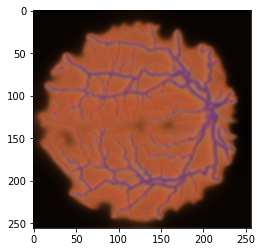

In [28]:
temp = Image.open('/content/drive/MyDrive/Unet0/saveImageOne/0.png')

plt.imshow(temp, cmap='gray')
plt.show()

In [29]:
transform1 = transforms.Grayscale()
temp = transform(temp)

In [33]:
save_image(temp,f'/content/drive/MyDrive/Unet0/saveImageOne/00.png')

# test